<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Chi-Nu Array Detector Angles

Author: Patricia Schuster  
Date: Fall 2016/Winter 2017  
Institution: University of Michigan NERS  
Email: pfschus@umich.edu

# What are we doing today?

Goal: Import and analyze the angles between all of the detector pairs in the Chi-Nu array.

As a reminder, this is what the Chi-Nu array looks like:

In [2]:
%%html
<img src="fig/setup.png",width=80%,height=80%>

There are 45 detectors in this array, making for 990 detector pairs:

In [2]:
45*44/2

990.0

In order to characterize the angular distribution of the neutrons and gamma-rays emitted in a fission interaction, we are going to analyze the data from pairs of detectors at different angles from one another. 

In this notebook I am going to import the detector angle data that Matthew provided me and explore the data. 

1) Import the angular data to a dictionary  
2) Visualize the angular data  
3) Find detector pairs in a given angular range  
4) Generate pairs vs. angle ranges

In [1]:
# Import packages
import os.path
import time
import numpy as np
np.set_printoptions(threshold=np.nan) # print entire matrices
import sys
import inspect
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import *
import pandas as pd

In [2]:
import seaborn as sns
sns.set_palette('spectral')
sns.set_style(style='white')

In [3]:
sys.path.append('../scripts/')
import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

# Step 1: Initialize pandas DataFrame with detector pairs

The detector pair angles are stored in a file `lanl_detector_angles.mat`. Write a function to load it as an array and then generate a pandas DataFrame

This was done before in `bicorr.build_dict_det_pair()`. Replace with a pandas dataFrame.

Columns will be:

* Detector 1
* Detector 2
* Index in `bicorr_hist_master`
* Angle between detectors

We can add more columns later very easily.

## Load channel lists

Use the function `bicorr.built_ch_lists()` to generate numpy arrays with all of the channel numbers:

In [37]:
help(bicorr.build_ch_lists)

Help on function build_ch_lists in module bicorr:

build_ch_lists(print_flag=False)
    Generate and return lists of the channel numbers that correspond to the fission chamber and detector channels. This is built for the Chi-Nu array measurements. If the detector array changes, we need to modify this function.
    
    Note: In the Chi-Nu array, the fission chamber channels correspond to detector channels as follows:
      - fc 0 det 1-15
      - fc 16 det 17-31
      - fc 32 det 33-47
      
    Run with: chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()
    
    Parameters
    ----------
    print_flag : bool, optional
        Print the values of all vectors?
    
    Returns
    -------
    chList : ndarray
        All channels measurements
    fcList : ndarray
        Fission chamber channels
    detList : ndarray
        Detector channels
    num_dets : int
        Number of detector channels
    num_det_pairs : int
        Number of pairs of detectors



In [6]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag = True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


## Initialize dataFrame with detector channel numbers

In [7]:
det_df = pd.DataFrame(columns=('d1', 'd2', 'd1d2', 'angle'))

The pandas dataFrame should have 990 entries, one for each detector pair. Generate this. 

In [8]:
# Fill pandas dataFrame with d1, d2, and d1d2 
count = 0
det_pair_chs = np.zeros(num_det_pairs,dtype=np.int)

# Loop through all detector pairs
for i1 in np.arange(0,num_dets):
    det1ch = detList[i1]
    for i2 in np.arange(i1+1,num_dets):
        det2ch = detList[i2]
        det_df.loc[count,'d1'  ] = det1ch
        det_df.loc[count,'d2'  ] = det2ch
        det_df.loc[count,'d1d2'] = 100*det1ch+det2ch
        count = count+1

In [9]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,NaN
1,1,3,103,NaN
2,1,4,104,NaN
3,1,5,105,NaN
4,1,6,106,NaN


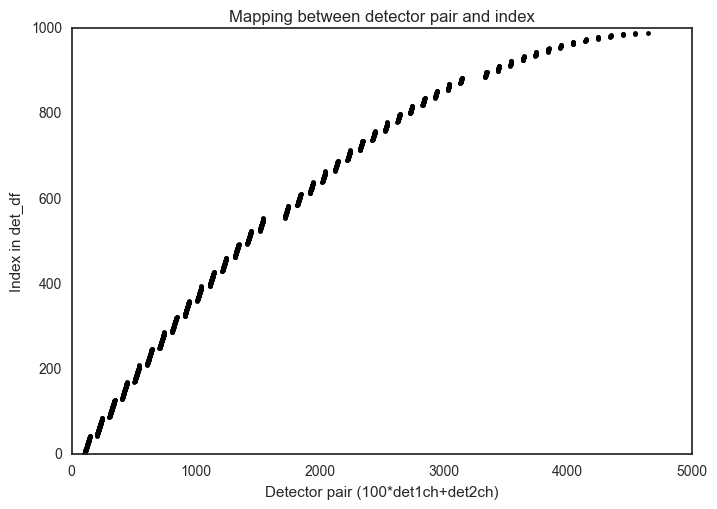

In [10]:
plt.plot(det_df['d1d2'],det_df.index,'.k')
plt.xlabel('Detector pair (100*det1ch+det2ch)')
plt.ylabel('Index in det_df')
plt.title('Mapping between detector pair and index')
plt.show()

## Visualize the dataFrame so far

Try using the built-in `pandas.DataFrame.plot` method.

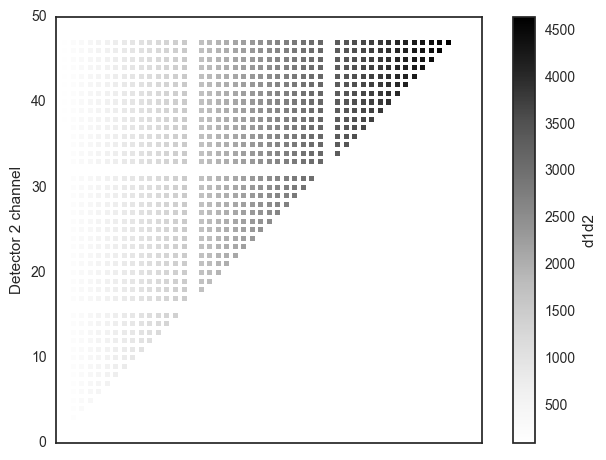

In [11]:
ax = det_df.plot('d1','d2',kind='scatter', marker = 's',edgecolor='none',s=13, c='d1d2')
plt.xlim([0,50])
plt.ylim([0,50])
ax.set_aspect('equal')
plt.xlabel('Detector 1 channel')
plt.ylabel('Detector 2 channel')

plt.show()

There are some problems with displaying the labels, so instead I will use `matplotlib` directly. I am writing a function to generate this plot since I will likely want to view it a lot.

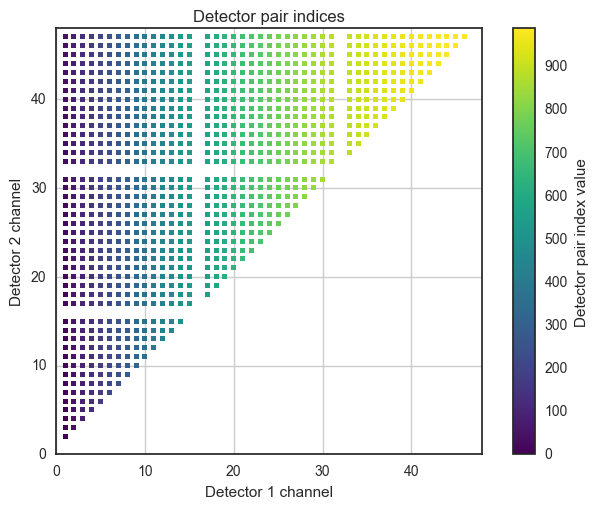

In [12]:
bicorr.plot_det_df(det_df, which=['index'])

# Step 2: Fill `angles` column

The `lanl_detector_angles.mat` file is located in my `measurements` folder:

In [13]:
os.listdir('../meas_info/')

['detector_positions.xlsx',
 'det_df.csv',
 'det_df.pkl',
 'det_df_pairs_angles.csv',
 'det_df_pairs_angles.pkl',
 'lanl_detector_angles.mat',
 'lanl_detector_angles_note.md']

What does this file look like? Import the `.mat` file and take a look.

In [14]:
det2detAngle = sio.loadmat('../meas_info/lanl_detector_angles.mat')['det2detAngle']
det2detAngle.shape

(57, 57)

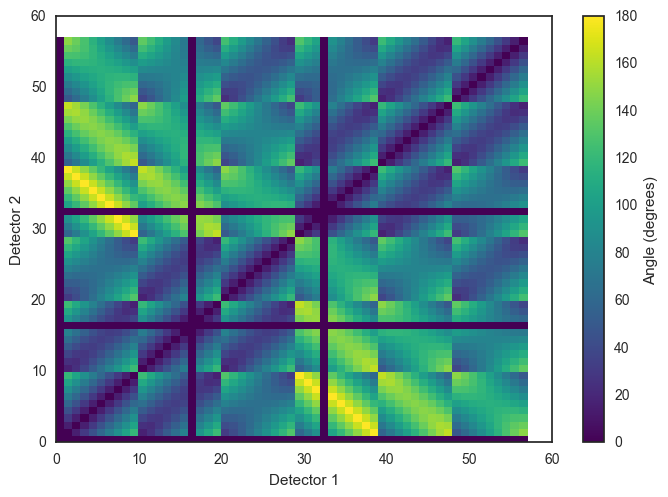

In [15]:
plt.pcolormesh(det2detAngle, cmap = "viridis")
cbar = plt.colorbar()
cbar.set_label('Angle (degrees)')
plt.xlabel('Detector 1')
plt.ylabel('Detector 2')
plt.show()

The array currently is `ndets x ndets` with an angle at every index. This is twice as many entries as we need because pairs are repeated at `(d1,d2)` and `(d2,d1)`. Loop through the pairs and store the angle to the dataframe.

## Fill the `'angle'` column of the DataFrame:

In [16]:
for pair in det_df.index:
    det_df.loc[pair,'angle'] = det2detAngle[int(det_df.loc[pair,'d1'])][int(det_df.loc[pair,'d2'])]

In [17]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15
1,1,3,103,30
2,1,4,104,45
3,1,5,105,60
4,1,6,106,75


## Visualize the angular data

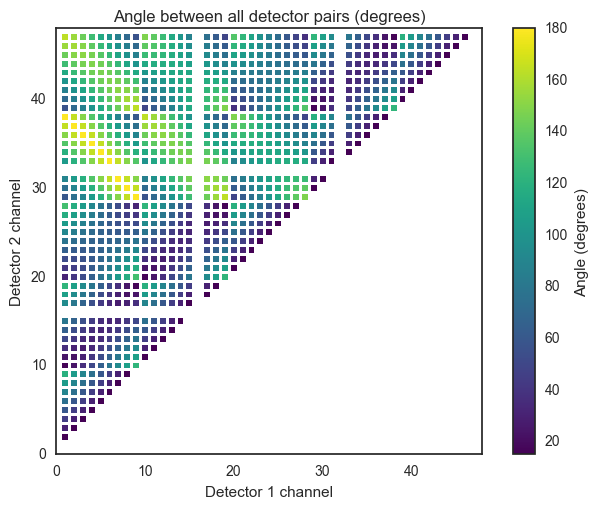

In [18]:
bicorr.plot_det_df(det_df,which=['angle'])

## Verify accuracy of `pandas` method

Make use of git to checkout old versions.

Previously, I generated a dictionary that mapped the detector pair `d1d2` index to the angle. Verify that the new method using pandas is producing the same array of angles. 

** Old version using channel lists, dictionary **

In [6]:
dict_pair_to_index, dict_index_to_pair = bicorr.build_dict_det_pair()

dict_pair_to_angle = bicorr.build_dict_pair_to_angle(dict_pair_to_index,foldername='../../measurements/')

det1ch_old, det2ch_old, angle_old = bicorr.unpack_dict_pair_to_angle(dict_pair_to_angle)

** New method using pandas det_df **

In [52]:
det_df = bicorr.load_det_df()

In [53]:
det1ch_new = det_df['d1'].values
det2ch_new = det_df['d2'].values
angle_new = det_df['angle'].values

** Compare the two **

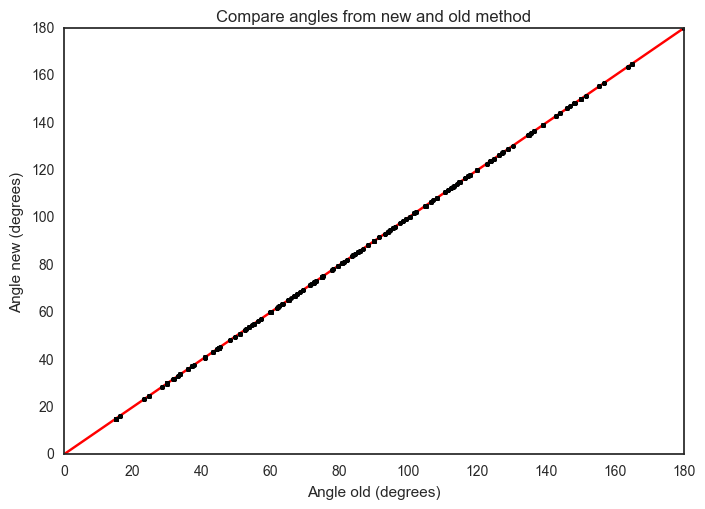

In [22]:
plt.plot([0,180],[0,180],'r')
plt.plot(angle_old, angle_new, '.k')
plt.xlabel('Angle old (degrees)')
plt.ylabel('Angle new (degrees)')
plt.title('Compare angles from new and old method')
plt.show()

Are the angle vectors within 0.001 degrees of each other? If so, then consider the two equal. 

In [27]:
np.sum((angle_old - angle_new) < 0.001)

990

Yes, consider them the same. 

# Step 3: Extract information from `det_df`

I need to exact information from `det_df` using the pandas methods. What are a few things I want to do?

In [54]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


## Return rows that meet a given condition

There are two primary methods for accessing rows in the dataFrame that meet certain conditions. In our case, the conditions may be which detector pairs or which angle ranges we want to access.

* Return a True/False mask indicating which entries meet the conditions
* Return a pandas Index structure containing the indices of those entries

As an example, I will look for rows in which `d2=8`. As a note, this will not be all entries in which channel 8 was involved because there are other pairs in which `d1=8` that will not be included.

** Return the rows **

Start with the mask method, which can be used to store our conditions.

In [55]:
d = 8
ind_mask = (det_df['d2'] == d)

In [56]:
# Get a glimpse of the mask's first five elements
ind_mask.head()

0    False
1    False
2    False
3    False
4    False
Name: d2, dtype: bool

In [57]:
# View the mask entries that are equal to true
ind_mask[ind_mask]

6      True
49     True
91     True
132    True
172    True
211    True
249    True
Name: d2, dtype: bool

The other method is to use the `.index` method to return a pandas index structure. Pull the indices from `det_df` using the mask.

In [211]:
ind = det_df.index[ind_mask]
print(ind)

Int64Index([6, 49, 91, 132, 172, 211, 249], dtype='int64')


** Count the number of rows **

Using the mask

In [212]:
np.sum(ind_mask)

7

Using the index structure

In [213]:
len(ind)

7

## Extract information for a single detector

** Find indices for that detector **

In [241]:
# A single detector, may be d1 or d2
d = 8
ind_mask = (det_df['d1']==d) | (det_df['d2']==d)
ind = det_df.index[ind_mask]

These lines can be accessed in `det_df` directly.

In [242]:
det_df[ind_mask].head()

,d1,d2,d1d2,angle
6,1,8,108,105
49,2,8,208,90
91,3,8,308,75
132,4,8,408,60
172,5,8,508,45


** Return a list of the other detector pair **

Since the detector may be `d1` or `d2`, I may need to return a list of the *other* pair, regardless of the order. How can I generate an array of the other detector in the pair?

In [243]:
det_df_this_det = det_df.loc[ind,['d1','d2']]

In [217]:
det_df_this_det.head()

,d1,d2
6,1,8
49,2,8
91,3,8
132,4,8
172,5,8


This is a really stupid method, but I can multiply the two detectors together and then divide by 8 to divide out that channel. 

In [218]:
det_df_this_det['dN'] = det_df_this_det.d1 * det_df_this_det.d2 / d

In [219]:
det_df_this_det.head()

,d1,d2,dN
6,1,8,1
49,2,8,2
91,3,8,3
132,4,8,4
172,5,8,5


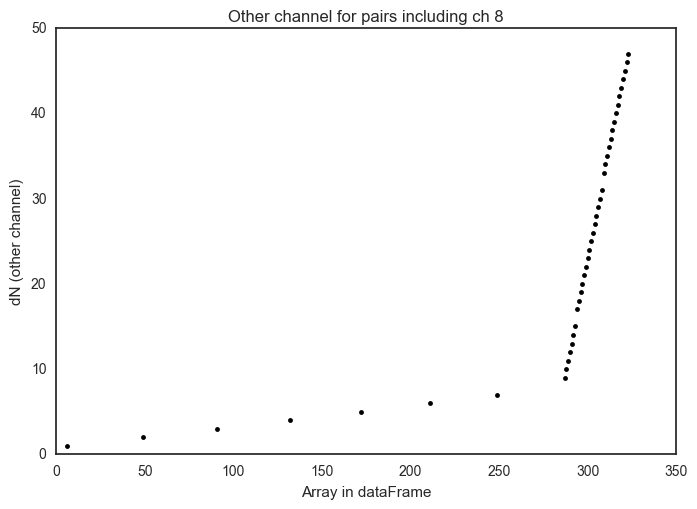

In [221]:
plt.plot(det_df_this_det['dN'],'.k')
plt.xlabel('Array in dataFrame')
plt.ylabel('dN (other channel)')
plt.title('Other channel for pairs including ch '+str(d))
plt.show()

** Return the angles **

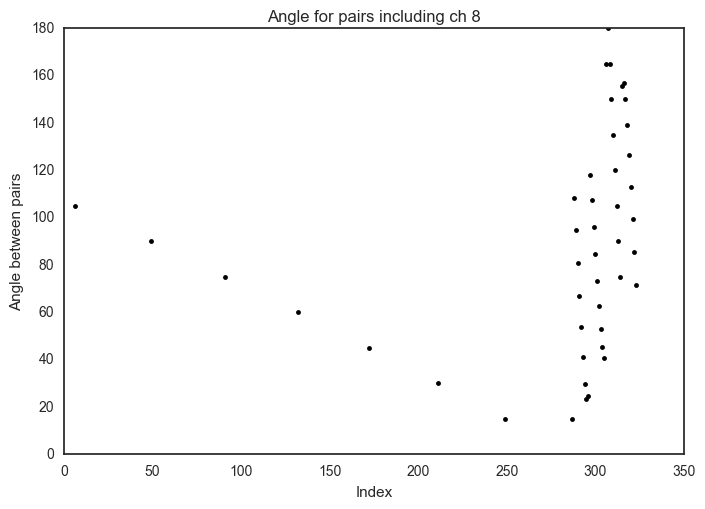

In [222]:
plt.plot(det_df.loc[ind,'angle'],'.k')
plt.xlabel('Index')
plt.ylabel('Angle between pairs')
plt.title('Angle for pairs including ch '+ str(d))
plt.show()

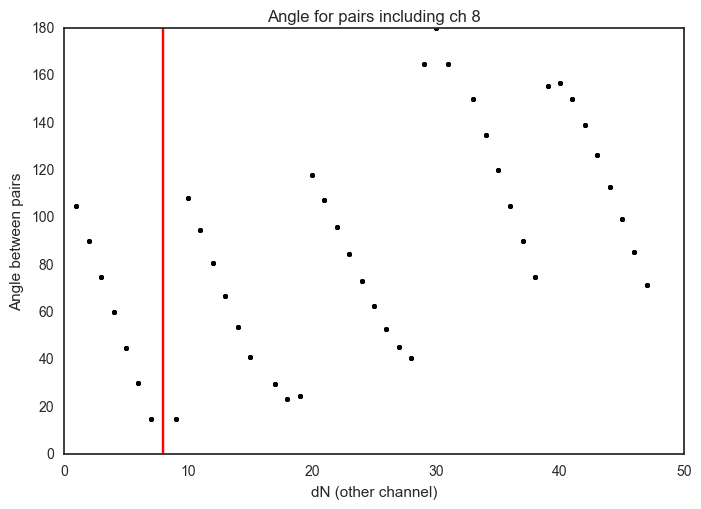

In [227]:
plt.plot(det_df_this_det['dN'],det_df.loc[ind,'angle'],'.k')
plt.axvline(d,color='r')
plt.xlabel('dN (other channel)')
plt.ylabel('Angle between pairs')
plt.title('Angle for pairs including ch '+ str(d))
plt.show()

## Extract information for a given pair

** Find indices for that pair **

In [21]:
d1 = 1
d2 = 4

if d2 < d1:
    print('Warning: d2 < d1. Channels inverted')

ind_mask = (det_df['d1']==d1) & (det_df['d2']==d2)
ind = det_df.index[ind_mask]

In [259]:
det_df[ind_mask]

,d1,d2,d1d2,angle
2,1,4,104,45


In [260]:
det_df[ind_mask]['angle']

2    45
Name: angle, dtype: object

I will write a function that returns the index.

In [29]:
bicorr.d1d2_index(det_df,4,1)

2

# Compare to speed of dictionary

For a large number of detector pairs, which is faster for retrieving the indices?

In [6]:
bicorr_data = bicorr.load_bicorr(bicorr_path = '../2017_01_09_pfs_build_bicorr_hist_master/1/bicorr1')
bicorr_data.shape

(3611942,)

In [8]:
det_df = bicorr.load_det_df()
dict_pair_to_index, dict_index_to_pair = bicorr.build_dict_det_pair()

In [11]:
d1 = 4
d2 = 8
print(dict_pair_to_index[100*d1+d2])
print(bicorr.d1d2_index(det_df,d1,d2))

132
132


Loop through `bicorr_data` and generate the index for all pairs.

** Using the dictionary method **

In [18]:
start_time = time.time()
for i in tqdm(np.arange(bicorr_data.size),ascii=True):
    d1 = bicorr_data[i]['det1ch']
    d2 = bicorr_data[i]['det2ch']
    index = dict_pair_to_index[100*d1+d2]
print(time.time()-start_time)

100%|##########| 3611942/3611942 [00:11<00:00, 308280.87it/s]


11.716399908065796


** Using the pandas dataFrame method **

In [ ]:
start_time = time.time()
for i in tqdm(np.arange(bicorr_data.size),ascii=True):
    d1 = bicorr_data[i]['det1ch']
    d2 = bicorr_data[i]['det2ch']
    index = bicorr.d1d2_index(det_df,d1,d2)
print(time.time()-start_time)

I'm not going to run this because `tqdm` says it will take approximately 24 minutes. So instead I should go with the dict method. But I would like to produce the dictionary from the pandas array directly. 

** Produce dictionaries from det_df **

Instead of relying on `dict_pair_to_index` all the time, I will generate it on the fly when filling `bicorr_hist_master` in `build_bicorr_hist_master` since that function requires generating the index so many times.

The three dictionaries that I need are:

* `dict_pair_to_index`
* `dict_index_to_pair`
* `dict_pair_to_angle`

In [7]:
det_df.index

RangeIndex(start=0, stop=990, step=1)

In [11]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


In [8]:
det_df[['d1d2','d2']].head()

,d1d2,d2
0,102,2
1,103,3
2,104,4
3,105,5
4,106,6


In [10]:
dict_index_to_pair = det_df['d1d2'].to_dict()
dict_pair_to_index = {v: k for k, v in dict_index_to_pair.items()}

In [16]:
dict_pair_to_angle = pd.Series(det_df['angle'].values,index=det_df['d1d2']).to_dict()

Functionalize these dictionaries so I can produce them on the fly.

In [17]:
help(bicorr.build_dict_det_pair)

Help on function build_dict_det_pair in module bicorr:

build_dict_det_pair(det_df)
    Build the dictionary that converts from detector pair to index and angle
    
    Parameters
    ----------
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles   
    
    Returns
    -------
    dict_pair_to_index : dict
        keys: detector pair indices (100*det1ch+det2ch)
        values: index of pair in bicorr_hist_master (along first axis)
    dict_index_to_pair : dict
        Reverse version of dict_pair_to_index
    dict_pair_to_angle : dict
        keys: detector pair indices (100*det1ch+det2ch)
        values : angle of pair



In [19]:
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

# Instructions: Save, load `det_df` file

I'm going to store the dataFrame using `to_pickle`. At this point, it only contains information on the pairs and angles. No `bin` column has been added.

In [19]:
det_df.to_pickle('../meas_info/det_df_pairs_angles.pkl')
det_df.to_csv('../meas_info/det_df_pairs_angles.csv',index = False)

Revive the dataFrame from the `.pkl` file. Write a function to do this automatically. Option to display plots.

In [20]:
help(bicorr.load_det_df)

Help on function load_det_df in module bicorr:

load_det_df(filepath='../meas_info/det_df_pairs_angles.csv', plot_flag=False)
    Load pandas dataFrame containing detector pair information and angles. This was created in the notebook `detector_pair_angles`.
    
    Parameters
    ----------
    filepath : str, optional
        Path (absolute or relative) to det_df file. May be `det_df.csv` or `det_df.csv`.
        Default location is specific to pfschus folder structure
    plot_flag : bool, optional
        Option to produce plots displaying basic structure of det_df
        Plots will be displayed but not stored
    
    Returns
    -------
    det_df : pandas dataFrame
        dataFrame of detector pair indices and angles



In [5]:
det_df = bicorr.load_det_df()
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


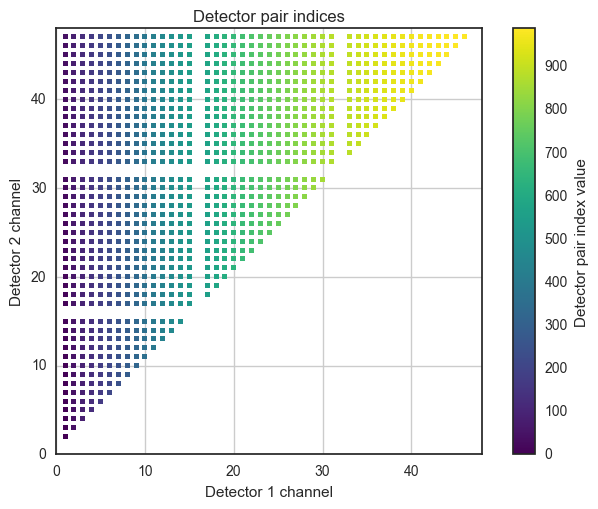

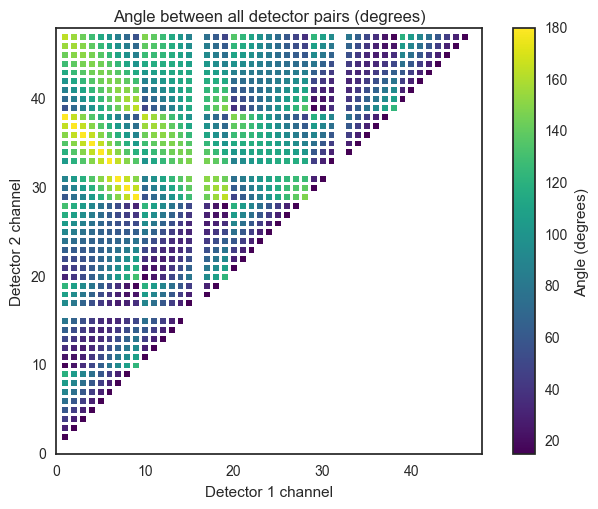

In [6]:
det_df = bicorr.load_det_df()
bicorr.plot_det_df(det_df, show_flag = True, which = ['index'])
bicorr.plot_det_df(det_df, show_flag = True, which = ['angle'])